In [48]:
# Embeddings from scratch - building word2vec

In [49]:
import torch

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
with open('text/breaking_bad_s02e08.txt', 'r') as file:
    text1 = file.read()
with open('text/breaking_bad_s02e09.txt', 'r') as file:
    text2 = file.read()
with open('text/breaking_bad_s02e10.txt', 'r') as file:
    text3 = file.read()

text = text1 + ' ' + text2 + ' ' + text3

In [52]:
import re
text = text.replace("\n", " ")
text = text.replace("  ", " ")
text = re.sub(r"[^a-zA-Z ]", "", text.lower())
# print(text)

In [53]:
# !pip install nltk

In [54]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import pos_tag
stop_words = set(stopwords.words('english'))
# text = " ".join([word for word in text.split() if word not in stop_words])
words = text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewvassili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [56]:
import re

def tokenize(text):
    text = text.lower().replace('.', '').replace(',', '').split(' ')
    return text

In [57]:
tokens = tokenize(text)

In [ ]:
# quick look at word frequencies
from collections import Counter

word_freq = Counter(tokens)
ordered_word_freq = word_freq.most_common()

for word, freq in ordered_word_freq:
    print(f"{word}: {freq}")

In [58]:
def map_tokens(tokens):
    token_to_id = {}
    id_to_token = {}
    unique_tokens = sorted(set(tokens))

    for i, token in enumerate(unique_tokens):
        token_to_id[token] = i
        id_to_token[i] = token

    return token_to_id, id_to_token

In [59]:
token_to_id, id_to_token = map_tokens(tokens)

In [61]:
def one_hot_encode(id, vocab_size):
    vec = torch.zeros(vocab_size, device=device)
    vec[id] = 1
    return vec

In [110]:
n_tokens = len(tokens)

In [115]:
import numpy as np
def generate_training_data(tokens, token_to_id, window):
    X = []
    y = []

    for i in range(n_tokens):
        idx_before = list(range(max(0, i - window), i))
        idx_after = list(range(i + 1, min(n_tokens, i + window + 1)))
        idx = idx_before + idx_after  # when i=5, idx will look like [2, 3, 4, 6, 7, 8] with the 5th element missing since it is the token of interest, x
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(token_to_id[tokens[i]], len(token_to_id)))
            y.append(one_hot_encode(token_to_id[tokens[j]], len(token_to_id)))

    X = torch.stack(X, dim=0)
    y = torch.stack(y, dim=0)

    return X, y

In [116]:
X, y = generate_training_data(tokens, token_to_id, 3)

In [118]:
def initialise_model(vocab_size, n_embedding):
    model = {
        "w1": torch.randn(vocab_size, n_embedding, requires_grad=True, device=device),
        "w2": torch.randn(n_embedding, vocab_size, requires_grad=True, device=device)
    }
    return model

In [170]:
model = initialise_model(len(token_to_id), 15)

In [171]:
import torch.nn.functional as F

def forward(model, X, return_cache=True):
    cache = {}
    cache["a1"] = X @ model["w1"]  # w1 is the dense representation
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = F.softmax(cache["a2"], dim=-1)

    if not return_cache:
        return cache["z"]
    return cache

In [173]:
def backward(model, X, y, lr):
    cache = forward(model, X)
    da2 = cache["z"] - y  # predicted minus actual
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1

    with torch.no_grad():
        model["w1"] -= lr * dw1
        model["w2"] -= lr * dw2

    return cross_entropy(cache["z"], y)

In [174]:
def cross_entropy(z, y):
    return -torch.sum(y * torch.log(z))

In [175]:
# !pip install matplotlib

In [183]:
import matplotlib.pyplot as plt
n_iter = 1000
learning_rate = 0.00050

history = []
for i in range(n_iter):
    loss = backward(model, X, y, learning_rate)
    history.append(loss.cpu().item())  # Move loss to CPU before converting to scalar
    print(f'Loop number: {i+1}, Loss: {loss.cpu().item()}')

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

Loop number: 1, Loss: 346825.96875
Loop number: 2, Loss: 345667.3125
Loop number: 3, Loss: 349727.6875
Loop number: 4, Loss: 366862.1875
Loop number: 5, Loss: 360240.6875
Loop number: 6, Loss: 350746.03125
Loop number: 7, Loss: 346677.40625
Loop number: 8, Loss: 343569.59375
Loop number: 9, Loss: 345076.65625
Loop number: 10, Loss: 344950.8125
Loop number: 11, Loss: 352072.5625
Loop number: 12, Loss: 384908.875
Loop number: 13, Loss: 366924.53125
Loop number: 14, Loss: 353347.5
Loop number: 15, Loss: 346244.375
Loop number: 16, Loss: 344216.46875
Loop number: 17, Loss: 346330.875
Loop number: 18, Loss: 350577.875
Loop number: 19, Loss: 356580.21875
Loop number: 20, Loss: 387462.8125
Loop number: 21, Loss: 371626.84375
Loop number: 22, Loss: 357116.75
Loop number: 23, Loss: 348667.3125
Loop number: 24, Loss: 345621.625
Loop number: 25, Loss: 350375.1875
Loop number: 26, Loss: 345740.625
Loop number: 27, Loss: 347356.3125
Loop number: 28, Loss: 351434.90625
Loop number: 29, Loss: 350188.

KeyboardInterrupt: 

In [182]:
# pass a token through the model and see prediction
token_x = 'saul' 
token_x_id = token_to_id[token_x]
print(token_x, token_x_id)
token_x_id_ohe = one_hot_encode(token_x_id, len(token_to_id))
cache = forward(model, token_x_id_ohe)
z = cache['z']
z_probs = F.softmax(z, dim=-1)
z_max = torch.argmax(z_probs)
predicted_word = id_to_token[int(z_max)]
print(predicted_word, int(z_max))

saul 1403
you 1873


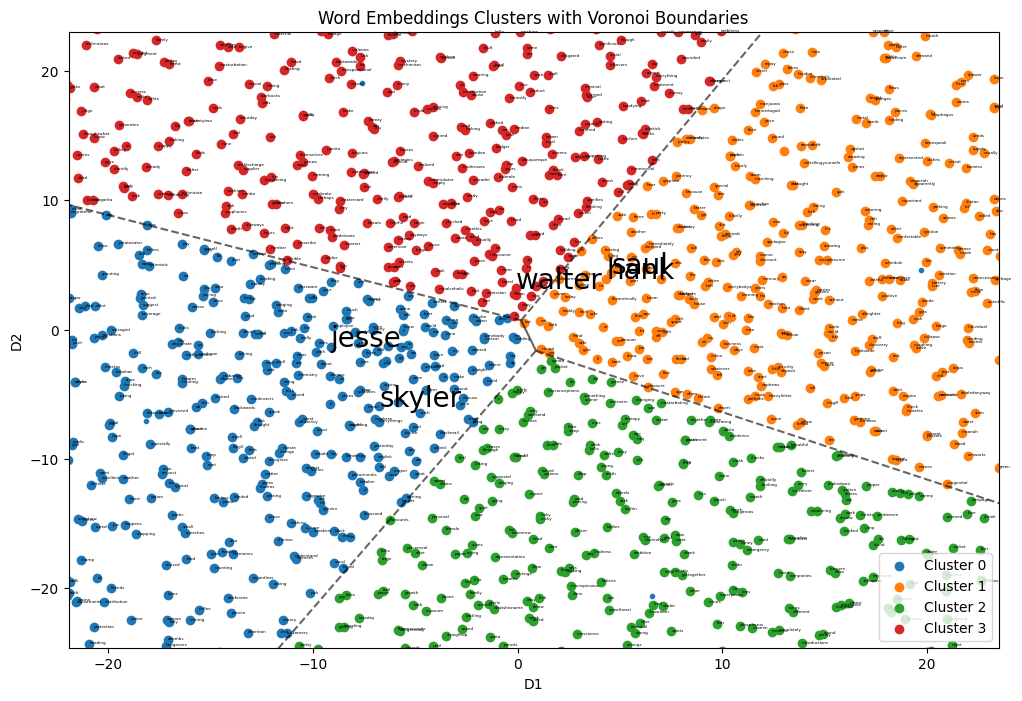

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(w1s_np)  # Shape: (101, 2)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(embeddings_2d)
cluster_centers = kmeans.cluster_centers_

vor = Voronoi(cluster_centers)
plt.figure(figsize=(12, 8))
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6)

for i in range(n_clusters):
    points = embeddings_2d[clusters == i]
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}')

vocabulary = list(tokens)
for i, word in enumerate(vocabulary):
    if word in ('heisenberg', 'walter', 'saul', 'hank', 'jesse', 'skyler'):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=20)
    else:
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=3)

plt.legend()
plt.title("Word Embeddings Clusters with Voronoi Boundaries")
plt.xlabel("D1")
plt.ylabel("D2")
plt.show()

In [ ]:
# start getting some gradio UI going

In [ ]:
# !pip install gradio

In [ ]:
# import gradio as gr

In [ ]:
# demo = gr.Interface(
#     fn=lambda x: f"Selected file: {x}",
#     inputs=gr.Dropdown(choices=["breaking_bad_s02e08.txt", "tiny_shakespeare_portion.txt", "seinfeld_the_opposite.txt"], label="Select a text file"),
#     outputs="text"
# )

In [ ]:
# demo.launch()